# Setup

In [1]:
# # Mount your google drive. This will launch a pop-up window for authentication.

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# # YOU SHOULD HAVE ALREADY COPIED THE ASSIGNMENT FILES TO THIS
# # FOLDER ON YOUR GOOGLE DRIVE

# #cd your_path_here
# %cd "/content/drive/My Drive/es-143-assignments/PROJECT/"

In [3]:
# # Install pupil_apriltags package. This a wrapper for the Apriltags3 library developed by AprilRobotics.
# # Documentation at https://github.com/pupil-labs/apriltags

# %pip install pupil-apriltags

In [1]:
# Import required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import os
from pupil_apriltags import Detector
import requests
import pickle
import glob   # filename and path management for file I/O

import plotly.express as px
import plotly.graph_objects as go

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

ModuleNotFoundError: No module named 'cv2'

In [5]:
# Fetch lists of target-IDs and 2D target locations (in inches) corresponding to the two
#   printed April boards.
response = requests.get("https://github.com/Harvard-CS283/pset-data/raw/f1a90573ae88cd530a3df3cd0cea71aa2363b1b3/april/AprilBoards.pickle")
data = pickle.loads(response.content)

at_coarseboard = data['at_coarseboard']
at_fineboard = data['at_fineboard']

In [6]:
#@title Helper function: `detect_aprilboard()`
# set up april tag detector (I use default parameters; seems to be OK)
at_detector = Detector(families='tag36h11',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

def detect_aprilboard(img, board, apriltag_detector):
    # Usage:  imgpoints, objpoints, tag_ids = detect_aprilboard(img,board,AT_detector)
    #
    # Input:
    #   image -- grayscale image
    #   board -- at_coarseboard or at_fineboard (list of dictionaries)
    #   AT_detector -- AprilTag Detector parameters
    #
    # Returns:
    #   imgpoints -- Nx2 numpy array of (x,y) image coords
    #   objpoints -- Nx3 numpy array of (X,Y,Z=0) board coordinates (in inches)
    #   tag_ids -- Nx1 list of tag IDs

    imgpoints=[]
    objpoints=[]
    tagIDs=[]

    # detect april tags
    imgtags = apriltag_detector.detect(img,
                                    estimate_tag_pose=False,
                                    camera_params=None,
                                    tag_size=None)

    if len(imgtags):
        # collect image coordinates of tag centers
        # imgpoints = np.vstack([ sub.center for sub in tags ])

        # list of all tag_id's that are in board
        brdtagIDs = [ sub['tag_id'] for sub in board ]

        # list of all detected tag_id's that are in image
        imgtagIDs = [ sub.tag_id for sub in imgtags ]

        # list of all tag_id's that are in both
        tagIDs = list(set(brdtagIDs).intersection(imgtagIDs))

        if len(tagIDs):
            # all board list-elements that contain one of the common tag_ids
            objs=list(filter(lambda tagnum: tagnum['tag_id'] in tagIDs, board))

            # their centers
            objpoints = np.vstack([ sub['center'] for sub in objs ])

            # all image list-elements that contain one of the detected tag_ids
            imgs=list(filter(lambda tagnum: tagnum.tag_id in tagIDs, imgtags))

            # their centers
            imgpoints = np.vstack([ sub.center for sub in imgs ])

    return imgpoints, objpoints, tagIDs

def in2hom(X):
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from Nxm homogeneous to Nx(m-1) inhomogeneous coordinates
def hom2in(X):
    return X[:, :-1] / X[:, -1:]

def intersect_ray_plane(plane, impts, calMatrix, distCoeffs):
    """
    3D intersection points from back-projected camera rays and a 3D plane

    Args:
      plane:      (a,b,c,d) plane parameters in camera coordinate system
      impts:      Nx2 array of pixel coordinates (xi,yi) to be back-projected
      calMatrix:  K-matrix as returned by cv2.calibrateCamera()
      distCoeffs: optical distortion coefficients as returned by cv2.calibrateCamera()

    Returns:
      intersections:  Nx3 array of 3D intersection-point coordinates (Xi,Yi,Zi)
    """

    # compute normalized coordinates (analogous to K^{-1}*x)
    impts_norm = cv2.undistortPoints(impts, calMatrix, distCoeffs)

    # remove extraneous leading size-1 axis that openCV returns (annoying)
    impts_norm = np.squeeze(impts_norm)

    # back-projections are homogeneous versions of these
    backproj = in2hom(impts_norm)

    # ray-plane intersection (use equation derived from Class Session slides)
    intersections_lambda = -plane[3]/np.dot(backproj,plane[:3])
    intersections = np.expand_dims(intersections_lambda,axis=1)*backproj

    return intersections

## Camera Calibration

17 images:


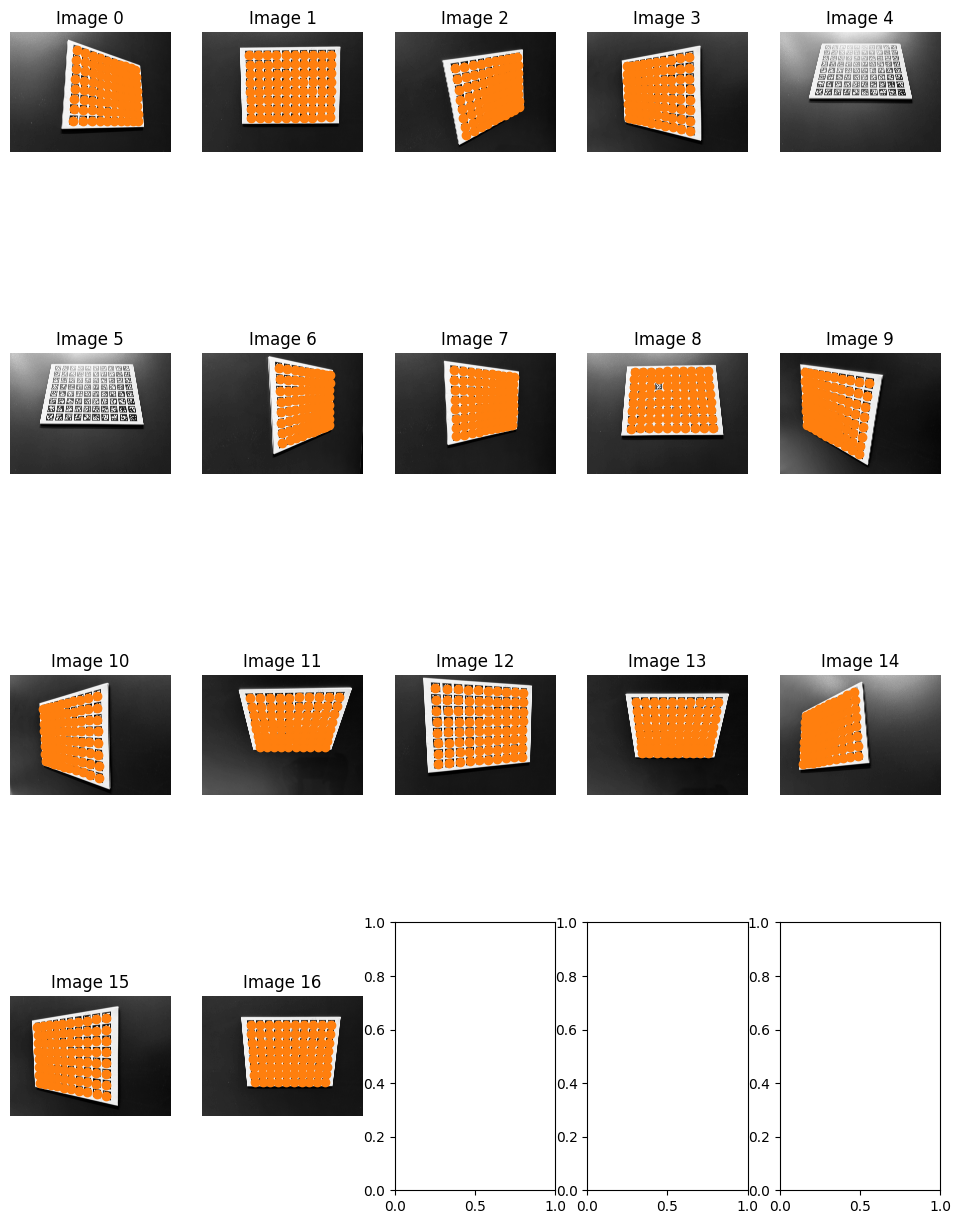

In [7]:
#@title detect fiducials

N = 70 # only use images with at least N detected objects for calibration
total_valid = 0

# Edit this line to point to the collection of input calibration image
CALIBFILES = './data/out_keyframes_*.jpeg'

# Uncomment one of the following two lines to indicate which AprilBoard is being used (fine or coarse)
BOARD = at_fineboard
#BOARD = at_coarseboard

###### BEGIN CALIBRATION SCRIPT

# exit if no images are found or if BOARD is unrecognized
images = glob.glob(CALIBFILES)
assert images, "no calibration images matching: " + CALIBFILES
assert BOARD==at_fineboard or BOARD==at_coarseboard, "Unrecognized AprilBoard"

# else continue
print("{} images:".format(len(images)))

# initialize 3D object points and 2D image points
calObjPoints = []
calImgPoints = []

# define the number of columns for the plot, then calculate number of rows
num_plot_cols = 5
num_plot_rows = (len(images) + num_plot_cols - 1) // num_plot_cols

# create the figure and axes; flatten the axes array for convenvience
fig, axs = plt.subplots(num_plot_rows, num_plot_cols, figsize=(12, 4*num_plot_rows))
axs = axs.flatten()

# loop through the images
for count,fname in enumerate(images):

    # read image and convert to grayscale if necessary
    orig = cv2.imread(fname)
    if len(orig.shape) == 3:
        img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
    else:
        img = orig

    # show image
    axs[count].imshow(img / 255.0, cmap="gray")
    axs[count].set_axis_off()
    axs[count].set_title("Image {}".format(count))

    # detect apriltags and report number of detections
    imgpoints, objpoints, tagIDs = detect_aprilboard(img,BOARD,at_detector)
    #print("{} {}: {} imgpts, {} objpts".format(count, fname, len(imgpoints),len(objpoints)))
    # print(f"{count} {fname}: {len(imgpoints)} imgpts, {len(objpoints)} objpts")

    # append detections if some are found
    if len(imgpoints) >= N and len(objpoints) >= N:
        total_valid += 1
        # display detected tag centers
        axs[count].scatter(imgpoints[:,0], imgpoints[:,1], marker='o', color='#ff7f0e')

        # append points detected in all images, (there is only one image now)
        calObjPoints.append(objpoints.astype('float32'))
        calImgPoints.append(imgpoints.astype('float32'))

# plt.show()

In [8]:
#@title calibrate camera

# calibrate the camera
reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = cv2.calibrateCamera(
    calObjPoints,
    calImgPoints,
    img.shape,    # uses image H,W to initialize the principal point to (H/2,W/2)
    None,         # no initial guess for the remaining entries of calMatrix
    None,         # initial guesses for distortion coefficients are all 0
    flags = None) # default contstraints (see documentation)

# Print output, including reprojection error, which is the root mean square (RMS)
#   re-projection error in pixels. If this value is much greater than 1, it is
#   likely to be a bad calibration.  Examine the images and detections, and the
#   options given to cv2.calibrateCamera() to figure out what went wrong.
np.set_printoptions(precision=5, suppress=True)
print('RMSE of reprojected points:', reprojerr)
print('Distortion coefficients:', distCoeffs)

np.set_printoptions(precision=2, suppress=True)
print('Intrinsic camera matrix:\n', calMatrix)
print('Total images used for calibration: ', total_valid)

extrinsic_matrices = []

for rotation, translation in zip(calRotations, calTranslations):
    rotation_matrix, _ = cv2.Rodrigues(rotation)
    extrinsic_matrix = np.hstack((rotation_matrix, translation))
    extrinsic_matrix = np.vstack((extrinsic_matrix, [0, 0, 0, 1]))
    extrinsic_matrices.append(extrinsic_matrix)

for i, extrinsic_matrix in enumerate(extrinsic_matrices):
    print(f"Extrinsic matrix for image {i+1}:\n{extrinsic_matrix}")


RMSE of reprojected points: 1.0468630545472921
Distortion coefficients: [[ 0.25643 -1.3481   0.00006  0.00073  2.2538 ]]
Intrinsic camera matrix:
 [[3037.05    0.   2012.5 ]
 [   0.   3040.13 1504.71]
 [   0.      0.      1.  ]]
Total images used for calibration:  15
Extrinsic matrix for image 1:
[[-0.03  0.85  0.52 -2.19]
 [ 0.98  0.13 -0.16 -5.1 ]
 [-0.2   0.51 -0.84 12.2 ]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 2:
[[ 0.01  1.   -0.01 -4.67]
 [ 1.   -0.01  0.06 -4.76]
 [ 0.06 -0.01 -1.   13.51]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 3:
[[ 0.12  0.81  0.58 -2.69]
 [ 0.95 -0.26  0.16 -2.57]
 [ 0.28  0.53 -0.8  10.24]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 4:
[[ 0.03  0.83 -0.56 -6.27]
 [ 1.    0.02  0.07 -4.16]
 [ 0.07 -0.56 -0.82 16.83]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 5:
[[ 0.04  0.75  0.66 -1.08]
 [ 0.99 -0.13  0.08 -4.66]
 [ 0.14  0.65 -0.74 10.08]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 6:
[[ 0.01

In [9]:
#@title Compute reprojection error separately in each image

# initial array for storing per-image reprojection errors
mean_errors=[]

# project 3D board points into the images, and compute the per-image reprojection error
for i in range(len(calObjPoints)):
    imgpoints2, _ = cv2.projectPoints(calObjPoints[i], calRotations[i], calTranslations[i], calMatrix, distCoeffs)
    mean_errors.append(np.mean(np.linalg.norm(calImgPoints[i] - np.squeeze(imgpoints2),axis=1)))

print("Per-image reprojection errors:")

# Print the list of per-image reprojection errors with at most 5 elements per line
print('\n'.join([', '.join([f"{error:.{5}f}" for error in mean_errors[i:i+5]]) for i in range(0, len(mean_errors), 5)]))

Per-image reprojection errors:
1.02846, 0.23954, 0.99440, 1.46179, 0.84810
1.21391, 0.75743, 0.41316, 0.58960, 1.01794
1.26150, 1.15351, 0.43191, 0.38533, 0.83497
